In [47]:
import os
os.system("git clone https://github.com/soerenetler/squad-question-generation.git")
os.system("git clone https://github.com/soerenetler/spacy_target_answer.git")
os.system("git clone https://github.com/soerenetler/crf_target_answer.git")

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [48]:
!(cd squad-question-generation/; git pull)
!(cd crf_target_answer/; git pull)

Already up to date.
Already up to date.


In [49]:
!cp crf_target_answer/Custom.py Custom.py
!cp crf_target_answer/model/evaluation_utils.py evaluation_utils.py

In [50]:
!pip install -r crf_target_answer/requirements.txt --quiet

In [51]:
import joblib
import eli5
import pandas as pd
#from FeatureTransformer import FeatureTransformer
import pandas as pd
import ast
import spacy
from Custom import *
from sklearn_crfsuite import metrics
from evaluation_utils import visualize_transitions, print_annotated_text, crf_roc_curve

In [52]:
import json

data_folder = "/content/gdrive/MyDrive/mt-qg-data/01_data/preprocessedData/"
model_folder = "/content/gdrive/MyDrive/mt-qg-data/00_models/crf_target_answer/"
dataset = "squad"
NO_SAMPLES = None

with open(data_folder + dataset+'/crf/'+str(NO_SAMPLES)+'_train_crf.txt') as f:
  data_json = json.load(f)
  train_feature = data_json["x"]
  y_train = data_json["y"]
  token_train = data_json["token"]

with open(data_folder + dataset+'/crf/'+str(NO_SAMPLES)+'_test_crf.txt') as f:
  data_json = json.load(f)
  test_feature = data_json["x"]
  y_test = data_json["y"]
  token_test = data_json["token"]

In [53]:
best_param={'c1': 0.1, 'c2': 1000}

crf = Custom_CRF(algorithm='lbfgs',
                  max_iterations=100,
                  min_freq=5,
                  all_possible_transitions=False,
                 **best_param)

In [54]:
%%time
crf.fit(train_feature, io2iob(y_train))

CPU times: user 11min 24s, sys: 4.59 s, total: 11min 29s
Wall time: 11min 27s


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Custom_CRF(algorithm='lbfgs', all_possible_states=None,
           all_possible_transitions=False, averaging=None, c=None, c1=0.1,
           c2=1000, calibration_candidates=None, calibration_eta=None,
           calibration_max_trials=None, calibration_rate=None,
           calibration_samples=None, delta=None, epsilon=None,
           error_sensitive=None, gamma=None, keep_tempfiles=None,
           linesearch=None, max_iterations=100, max_linesearch=None, min_freq=5,
           model_filename=None, num_memories=None, pa_type=None, period=None,
           trainer_cls=None, variance=None, verbose=False)

In [55]:
joblib.dump(crf, model_folder +dataset + "/" +  'final_estimator.pkl')

['/content/gdrive/MyDrive/mt-qg-data/00_models/crf_target_answer/squad/final_estimator.pkl']

In [40]:
y_pred_test = crf.predict(test_feature)
y_pred_test_marginals = crf.predict_proba(test_feature)

y_pred_train = crf.predict(train_feature)
y_pred_train_marginals = crf.predict_proba(train_feature)

In [41]:
print(y_pred_test_marginals[0])

[{'O': 0.9124330897662901, 'B-Answer': 0.07714857775480988, 'I-Answer': 0.01041833247889888}, {'O': 0.8355818391272444, 'B-Answer': 0.07848447532174592, 'I-Answer': 0.08593368555100869}, {'O': 0.9702893989460393, 'B-Answer': 0.0021998765602840704, 'I-Answer': 0.0275107244936759}, {'O': 0.9002633958292768, 'B-Answer': 0.06873606978778826, 'I-Answer': 0.031000534382934385}, {'O': 0.9631977702261774, 'B-Answer': 0.0024800979498409283, 'I-Answer': 0.03432213182398095}, {'O': 0.8965855553268464, 'B-Answer': 0.06481756333309652, 'I-Answer': 0.03859688134005638}, {'O': 0.9686979431316283, 'B-Answer': 0.0025641764277194424, 'I-Answer': 0.028737880440651356}, {'O': 0.9030193720538973, 'B-Answer': 0.06291046856214695, 'I-Answer': 0.034070159383955016}, {'O': 0.9569021877991145, 'B-Answer': 0.00304664843468746, 'I-Answer': 0.040051163766197474}, {'O': 0.8858198994320107, 'B-Answer': 0.0672834428387206, 'I-Answer': 0.046896657729268036}, {'O': 0.9542837186850387, 'B-Answer': 0.0035402179529121073,

              precision    recall  f1-score   support

    B-Answer    0.46154   0.00594   0.01173      8080
    I-Answer    0.53254   0.00328   0.00652     27451
           O    0.79968   0.99911   0.88834    141383

    accuracy                        0.79923    176914
   macro avg    0.59792   0.33611   0.30220    176914
weighted avg    0.74279   0.79923   0.71148    176914



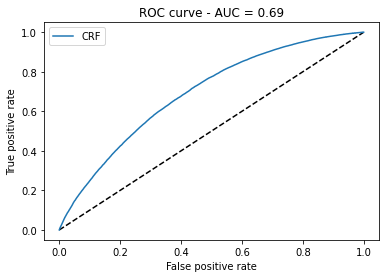

In [42]:
# Evaluate Standard Evaluation Metricies

print(metrics.flat_classification_report(io2iob(y_test), y_pred_test, digits=5))
crf_roc_curve(io2iob(y_test), y_pred_test_marginals)

              precision    recall  f1-score   support

    B-Answer    0.48722   0.00821   0.01614     76656
    I-Answer    0.44704   0.00562   0.01110    200480
           O    0.86585   0.99889   0.92762   1778924

    accuracy                        0.86510   2056060
   macro avg    0.60004   0.33757   0.31829   2056060
weighted avg    0.81090   0.86510   0.80427   2056060



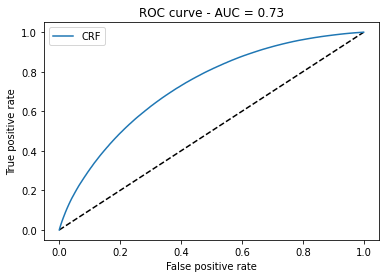

In [43]:
# Evaluate Standard Evaluation Metricies
print(metrics.flat_classification_report(io2iob(y_train), y_pred_train, digits=5))
crf_roc_curve(io2iob(y_train), y_pred_train_marginals)

In [44]:
eli5.show_weights(crf, top=100)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


## .......

'I-Answer'

In [46]:
for tokens, margials, y_pred, y in zip(token_test, y_pred_test_marginals, y_pred_test, y_test):
  if not set(y_pred) == set(["O"]):
    print()
    print_annotated_text(tokens, margials, y)

In [15]:
# Print one example output
paragraph = nlp("A Japan-exclusive manga series based on Twilight Princess, penned and illustrated by Akira Himekawa, was first released on February 8, 2016. The series is available solely via publisher Shogakukan's MangaOne mobile application. While the manga adaptation began almost ten years after the initial release of the game on which it is based, it launched only a month before the release of the high-definition remake.")
y_true = ['O', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'O', 'O', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

tokens =[token.text for token in paragraph]
y_pred = model.predict_marginals_single(text2features(paragraph, pos_features=POS_FEATURES, ent_type_features=ENT_TYPE_FEATURES, lemma_features=LEMMA_FEATURES, is_features=IS_FEATURES, position_features=POSITION_FEATURES, bias=BIAS, begin=BEGIN, end=END))
print_annotated_text(tokens, y_pred, y_trues=y_true)

NameError: ignored

In [ ]:
# Print 100 randomly sampled text
from IPython.display import Latex
for index, row in df_askable_paragraph_test.iterrows(): #.sample(n=100, random_state=1)
    if nlp(row["paragraph_context"])[:3].text == "The Norman dynasty":
        paragraph = nlp(row["paragraph_context"])
        y_true = row["askable_tokens"]
        tokens =[token.text for token in paragraph]
        y_pred = model.predict_marginals_single(text2features(paragraph, pos_features=POS_FEATURES, ent_type_features=ENT_TYPE_FEATURES, lemma_features=LEMMA_FEATURES, is_features=IS_FEATURES, position_features=POSITION_FEATURES, bias=BIAS, begin=BEGIN, end=END))

        print_annotated_text(tokens, y_pred, y_trues=y_true)
        Latex(print_annotated_text_latex(tokens, y_pred, y_trues=y_true))